# Capture + sequencing combined process simulation

This notebook is aimed at simulating a two stage dropout process where sequences are captured, then sequenced. We would like to demonstrate that these two processes can be summarized in a single capture process.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


### Hypergeometric vs binomial simulation

In [5]:
N = 2000
q = 0.1
true_value = 3

hyper = stats.hypergeom.rvs(N, true_value, int(N*q), size=100000)
binom = stats.binom.rvs(true_value, q, size=100000)

In [6]:
hyper.mean()

0.29927

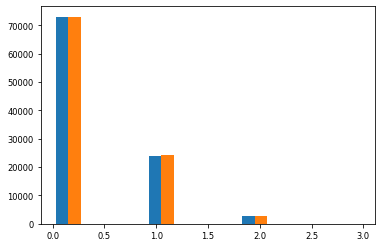

In [7]:
plt.hist([hyper, binom]);

### Function for simulating transcriptomes based on NB distributions

In [56]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def simulate_transcriptomes(n_cells, n_genes):
    
    params = stats.multivariate_normal.rvs(mean=[-1, 2], cov=np.array([[4, 0], [0, 0.4]]), size=n_genes)
    means, residual_variances = np.exp(params[:, 0]), np.exp(params[:, 1])
    variances = means*residual_variances
    dispersions = (variances - means)/means**2
    dispersions[dispersions < 0] = 1e-5
    thetas = 1/dispersions

    return stats.nbinom.rvs(*convert_params(means, thetas), size=(n_cells, n_genes))


def capture_sampling(transcriptomes, q, q_sq):
    
    m = q
    v = q_sq - q**2
    alpha = m*(m*(1-m)/v - 1)
    beta = (1-m)*(m*(1-m)/v - 1)
    qs = stats.beta.rvs(alpha, beta, size=transcriptomes.shape[0])
    
    captured_transcriptomes = []
    for i in range(transcriptomes.shape[0]):
        captured_transcriptomes.append(
            gen.multivariate_hypergeometric(transcriptomes[i, :], np.round(qs[i]*transcriptomes[i, :].sum()).astype(int))
        )
    
    return qs, np.vstack(captured_transcriptomes)


def sequencing_sampling(transcriptomes):
    
    observed_transcriptomes = np.zeros(transcriptomes.shape)
    num_molecules = transcriptomes.sum()
    print(num_molecules)
    
    for i in range(n_cells):
        for j in range(n_genes):
            
            observed_transcriptomes[i, j] = (stats.binom.rvs(n=int(num_reads), p=1/num_molecules, size=transcriptomes[i, j]) > 0).sum()
            
    return observed_transcriptomes

### Define simulation parameters

In [65]:
n_cells = 10000
n_genes = 5000
q = 0.1
q_sq = 0.012
noise_level = q_sq/q**2-1
num_reads = 2000000
sequencing_capture_efficiency = 1

### Simulate a transcriptome - no sequencing noise

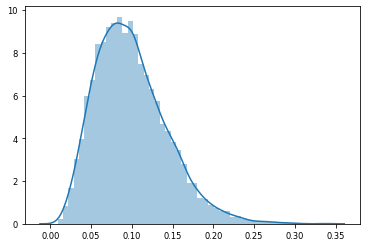

In [66]:
gen = np.random.Generator(np.random.PCG64(42343))
transcriptome = simulate_transcriptomes(n_cells, n_genes)
real_content = transcriptome.sum(axis=1)
qs, observed_transcriptome = capture_sampling(transcriptome, q, q_sq)
observed_content = observed_transcriptome.sum(axis=1)
sns.distplot(qs)

# Construct the AnnData object
adata = sc.AnnData(observed_transcriptome)
adata.obs['n_counts'] = observed_transcriptome.sum(axis=1)
adata.obs['cell_type'] = 'A'

# define interesting variables
x_true = np.log(transcriptome.mean(axis=0))
y_true = np.log(transcriptome.var(axis=0))
x_obs = np.log(observed_transcriptome.mean(axis=0))
y_obs = np.log(observed_transcriptome.var(axis=0))

### Estimate beta_sq based on the poisson assumption then the correlation minimization

In [67]:
import warnings
warnings.filterwarnings("ignore")

E[q^2] falls in [0.01000, 0.01193942], with the current estimate of 0.01193340
upper limit 0.011939424624285181
estimated 0.011933401508354143
true value 0.012
lower limit 0.010000000000000002


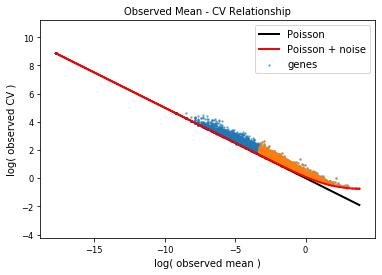

In [68]:
imp.reload(scmemo)
imp.reload(utils)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=q)
estimator.compute_observed_moments(verbose=False)

# Estimate q_sq
estimator.estimate_beta_sq(frac=0.5)
#estimator.beta_sq = 0.01287669
estimator.plot_cv_mean_curve()

# Estimate the true moments
estimator.estimate_1d_parameters()
x = np.log(estimator.estimated_central_moments['all']['first'])
y = np.log(estimator.estimated_central_moments['all']['second'])

# Define the limits
q_sq_lower_lim = estimator.beta**2
observed_content = observed_transcriptome.sum(axis=1)
q_sq_upper_lim = (observed_content**2).mean()/observed_content.mean()**2*estimator.beta**2
print('upper limit', q_sq_upper_lim)
print('estimated', estimator.beta_sq)
print('true value', q_sq)
print('lower limit', q_sq_lower_lim)

Text(0.5, 0, 'Log(mean)')

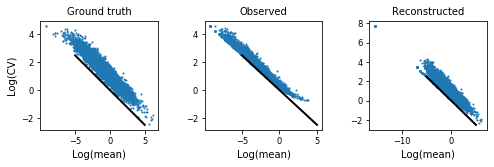

In [70]:
plt.figure(figsize=(8, 2))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 3, 1)
plt.scatter(x_true, y_true/2-x_true, s=1)
plt.plot(np.array([-5, 5]), -1*np.array([-5, 5])/2,'k', lw=2)
plt.title('Ground truth')
plt.xlabel('Log(mean)')
plt.ylabel('Log(CV)')

plt.subplot(1, 3, 2)
plt.scatter(x_obs, y_obs/2-x_obs, s=1)
plt.plot(np.array([-5, 5]), -1*np.array([-5, 5])/2,'k', lw=2)
plt.title('Observed')
plt.xlabel('Log(mean)')


plt.subplot(1, 3, 3)
plt.scatter(x, y/2-x, s=1)
plt.plot(np.array([-5, 5]), -1*np.array([-5, 5])/2,'k', lw=2)
plt.title('Reconstructed')
plt.xlabel('Log(mean)')




### Run the simulation - with composite error from capture + sequencing

In [63]:
_, _, transcriptome = simulate_transcriptomes(n_cells, n_genes)
real_content = transcriptome.sum(axis=1)


ValueError: too many values to unpack (expected 3)

In [ ]:
qs, captured_transcriptome = capture_sampling(transcriptome, q, q_sq)

In [ ]:
observed_transcriptome = stats.binom.rvs(captured_transcriptome, p=sequencing_capture_efficiency)


### Estimate overall noise parameters - Poisson assumption method

In [ ]:
observed_means = observed_transcriptome.mean(axis=0)
observed_vars = observed_transcriptome.var(axis=0)
observed_cv_sq = observed_vars/observed_means**2

In [ ]:
adata = sc.AnnData(observed_transcriptome)
adata.obs['n_counts'] = observed_transcriptome.sum(axis=1)

In [ ]:
overall_q_sq/overall_q**2-1

In [ ]:
estimated_noise_level

In [ ]:
x = observed_means
y = observed_vars
estimated_noise_level = np.percentile(
    (y/x**2 - 1/x), 
    q=40)
overall_q = observed_transcriptome.sum()/captured_transcriptome.sum() * q
overall_q_sq = (estimated_noise_level + 1)*overall_q**2

plt.scatter(
    np.log(observed_means),
    np.log(observed_cv_sq),
    s=5
)
bound_x = np.arange(
    np.nanmin(observed_means),
    np.nanmax(observed_means),
    0.01)
bound_y = 1/bound_x + estimated_noise_level

plt.plot(np.log(bound_x), -np.log(bound_x), color='k', lw=2)
plt.plot(np.log(bound_x), np.log(bound_y), lw=2, color='r')
plt.axis('equal');
plt.legend(['Poisson', 'Poisson + noise', 'genes'])
plt.title('Observed Mean - CV Relationship');
plt.xlabel('log( observed mean )')
plt.ylabel('log( observed CV^2 )')

In [ ]:
(qs**2).mean()

In [ ]:
overall_q_sq

In [ ]:
overall_q

### Perform a single step of dropout

In [ ]:
approx_observed_transcriptome = capture_sampling(transcriptome, overall_q, overall_q_sq)
sns.distplot(observed_transcriptome.sum(axis=1), hist=False, label='Sequenced transcripts', kde_kws={'lw':5})
sns.distplot(approx_observed_transcriptome.sum(axis=1), hist=False, label='One set hypergeometric', kde_kws={'lw':5, 'linestyle':':'})
sns.distplot(captured_transcriptome.sum(axis=1), hist=False, label='Captured transcripts', kde_kws={'lw':5})
sns.distplot(transcriptome.sum(axis=1), hist=False, label='True mRNA content', kde_kws={'lw':5})

plt.title('Distribution of simulated mRNA content in cells')
plt.xlabel('Count');plt.ylabel('Density')
plt.savefig('capture_seq_rna_content.pdf', bbox_inches='tight');
#sns.distplot(transcriptome.sum(axis=1))